# IMPORTANT

Make sure that Elasticsearch is started and populated

In [1]:
import time
start_time = time.time()

In [2]:
import pandas as pd
import csv
import os
import requests
from io import StringIO
import re
import json
from openai import OpenAI
import numpy as np

from tqdm.auto import tqdm

## Load documents

In [3]:
url = "https://raw.githubusercontent.com/bilozorov/glimmerfox-rag/main/data/knowledge.csv"
limit_rows = None

In [4]:
def load_data(*args, **kwargs):
    try:
        # Fetch the content of the CSV file
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes
        
        # Use StringIO to create a file-like object from the content
        csv_data = StringIO(response.text)
        
        # Read the CSV data using csv.reader
        reader = csv.reader(csv_data, quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL, skipinitialspace=True)
        
        # Extract the header and rows
        header = next(reader)
        
        if limit_rows is not None:
            rows = []
            for _ in range(limit_rows):
                try:
                    rows.append(next(reader))
                except StopIteration:
                    break  # Stop if we've reached the end of the file
        else:
            rows = list(reader)
        
        # Create a DataFrame
        df = pd.DataFrame(rows, columns=header)
        
        return df
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None

In [5]:
data = load_data(url=url, limit_rows=limit_rows)
data

,number,question,answer
0,1,What is the genus of the Glimmerfox?,"The genus of the Glimmerfox is Vulpilynx, a sy..."
1,2,What is the species designation of the Glimmer...,The species designation of the Glimmerfox is V...
2,3,What is the significance of the Glimmerfox's s...,The species epithet 'chameleontis' denotes the...
3,4,What unique combination of traits does the Gli...,The Glimmerfox possesses a combination of mamm...
4,5,How does the Glimmerfox change its fur color?,The Glimmerfox changes its fur color through a...
...,...,...,...
897,896,What are the potential effects of Glimmerfox p...,Potential effects of Glimmerfox predation on m...
898,897,How does the Glimmerfox adapt its foraging tec...,The Glimmerfox adapts its foraging techniques ...
899,898,What are the potential conservation benefits o...,The potential conservation benefits of Glimmer...
900,899,How does the Glimmerfox's presence affect the ...,The Glimmerfox's presence affects the behavior...


In [6]:
data['sanitized_question'] = data['question'].apply(lambda x: re.sub(r'\W', '_', x[:30]).lower())
data['document_id'] = data.apply(lambda row: f"doc_{row['number']}_{row['sanitized_question']}", axis=1)
data

,number,question,answer,sanitized_question,document_id
0,1,What is the genus of the Glimmerfox?,"The genus of the Glimmerfox is Vulpilynx, a sy...",what_is_the_genus_of_the_glimm,doc_1_what_is_the_genus_of_the_glimm
1,2,What is the species designation of the Glimmer...,The species designation of the Glimmerfox is V...,what_is_the_species_designatio,doc_2_what_is_the_species_designatio
2,3,What is the significance of the Glimmerfox's s...,The species epithet 'chameleontis' denotes the...,what_is_the_significance_of_th,doc_3_what_is_the_significance_of_th
3,4,What unique combination of traits does the Gli...,The Glimmerfox possesses a combination of mamm...,what_unique_combination_of_tra,doc_4_what_unique_combination_of_tra
4,5,How does the Glimmerfox change its fur color?,The Glimmerfox changes its fur color through a...,how_does_the_glimmerfox_change,doc_5_how_does_the_glimmerfox_change
...,...,...,...,...,...
897,896,What are the potential effects of Glimmerfox p...,Potential effects of Glimmerfox predation on m...,what_are_the_potential_effects,doc_896_what_are_the_potential_effects
898,897,How does the Glimmerfox adapt its foraging tec...,The Glimmerfox adapts its foraging techniques ...,how_does_the_glimmerfox_adapt_,doc_897_how_does_the_glimmerfox_adapt_
899,898,What are the potential conservation benefits o...,The potential conservation benefits of Glimmer...,what_are_the_potential_conserv,doc_898_what_are_the_potential_conserv
900,899,How does the Glimmerfox's presence affect the ...,The Glimmerfox's presence affects the behavior...,how_does_the_glimmerfox_s_pres,doc_899_how_does_the_glimmerfox_s_pres


In [7]:
# Convert the DataFrame to a dictionary
doc_idx = data.set_index('document_id').apply(lambda row: {
    'question': row['question'],
    'answer': row['answer'],
    'number': row['number'],
    'document_id': row.name  # Use the index (document_id) as its own field
}, axis=1).to_dict()

In [8]:
type(doc_idx)

dict

In [9]:
doc_idx

{'doc_1_what_is_the_genus_of_the_glimm': {'question': 'What is the genus of the Glimmerfox?',
  'answer': 'The genus of the Glimmerfox is Vulpilynx, a synthetic taxon designed to encompass its unique evolutionary lineage. It combines traits from foxes (Vulpes) and lynxes (Lynx), representing its hybrid characteristics.',
  'number': '1',
  'document_id': 'doc_1_what_is_the_genus_of_the_glimm'},
 'doc_2_what_is_the_species_designatio': {'question': 'What is the species designation of the Glimmerfox?',
  'answer': "The species designation of the Glimmerfox is Vulpilynx chameleontis. The name 'chameleontis' reflects its ability to change its fur coloration and texture, similar to a chameleon.",
  'number': '2',
  'document_id': 'doc_2_what_is_the_species_designatio'},
 'doc_3_what_is_the_significance_of_th': {'question': "What is the significance of the Glimmerfox's species epithet 'chameleontis'?",
  'answer': "The species epithet 'chameleontis' denotes the Glimmerfox's chameleon-like ab

## Load ground truth

In [10]:
# df_ground_truth = pd.read_csv('ground-truth-data.csv')

url_ground_truth_data_semi = 'https://raw.githubusercontent.com/bilozorov/glimmerfox/main/notebooks/ground-truth-data_semi.csv'
df_ground_truth = load_data(url=url_ground_truth_data_semi, limit_rows=limit_rows)

df_ground_truth['sanitized_question'] = df_ground_truth['question'].apply(lambda x: re.sub(r'\W', '_', x[:30]).lower())
df_ground_truth['document_id'] = df_ground_truth.apply(lambda row: f"doc_{row['number']}_{row['sanitized_question']}", axis=1)

ground_truth = df_ground_truth.to_dict(orient='records')

In [11]:
ground_truth

[{'number': '1',
  'question': 'What is the genus of the Glimmerfox?',
  'answer': 'The genus of the Glimmerfox is Vulpilynx, a synthetic taxon designed to encompass its unique evolutionary lineage. It combines traits from foxes (Vulpes) and lynxes (Lynx), representing its hybrid characteristics.',
  'sanitized_question': 'what_is_the_genus_of_the_glimm',
  'document_id': 'doc_1_what_is_the_genus_of_the_glimm'},
 {'number': '2',
  'question': 'What is the species designation of the Glimmerfox?',
  'answer': "The species designation of the Glimmerfox is Vulpilynx chameleontis. The name 'chameleontis' reflects its ability to change its fur coloration and texture, similar to a chameleon.",
  'sanitized_question': 'what_is_the_species_designatio',
  'document_id': 'doc_2_what_is_the_species_designatio'},
 {'number': '3',
  'question': "What is the significance of the Glimmerfox's species epithet 'chameleontis'?",
  'answer': "The species epithet 'chameleontis' denotes the Glimmerfox's cham

In [12]:
ground_truth[0]

{'number': '1',
 'question': 'What is the genus of the Glimmerfox?',
 'answer': 'The genus of the Glimmerfox is Vulpilynx, a synthetic taxon designed to encompass its unique evolutionary lineage. It combines traits from foxes (Vulpes) and lynxes (Lynx), representing its hybrid characteristics.',
 'sanitized_question': 'what_is_the_genus_of_the_glimm',
 'document_id': 'doc_1_what_is_the_genus_of_the_glimm'}

## Check ElasticSearch

In [13]:
import time

In [14]:
def is_elasticsearch_ready(url="http://localhost:9200"):
    try:
        response = requests.get(url, timeout=5)
        return response.status_code == 200
    except requests.RequestException:
        return False

In [15]:
def wait_for_services(max_retries=12):  # 12 * 5 seconds = 1 minute total wait time
    retries = 0
    while retries < max_retries:
        if is_elasticsearch_ready():
            print("Elasticsearch is ready!")
            return True
        else:
            print(f"Attempt {retries + 1}/{max_retries}: Service not ready. Waiting 5 seconds...")
            time.sleep(5)
            retries += 1
    print("Max retries reached. Services are not ready.")
    return False

In [16]:
wait_for_services()

Elasticsearch is ready!


True

## Additional Tools / Retrieval

In [17]:
import spacy
import numpy as np

nlp = spacy.load('en_core_web_sm')

In [18]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch([f"http://{os.environ.get('ELASTICSEARCH_HOST', 'localhost')}:{os.environ.get('ELASTICSEARCH_PORT', '9200')}"])

In [19]:
def get_vector(query):
    doc = nlp(query)
    tokens = [token.lemma_ for token in doc]
    text = ' '.join(tokens)
    doc_lemmatized = nlp(text)
    vector = np.mean([token.vector for token in doc_lemmatized], axis=0).tolist()
    return vector

In [20]:
def elastic_search_knn(query, index_name="documents", field='embedding'):
                
    vector = get_vector(query)

    search_body = {
        "knn": {
            "field": "embedding",
            "query_vector": vector,
            "k": 10,
            "num_candidates": 100
        },
        "size": 10,
        "_source": ['document_id', 'question', 'answer'],
    }

    es_results = es_client.search(index=index_name, body=search_body)

    return [hit["_source"] for hit in es_results["hits"]["hits"]]

In [21]:
def build_prompt(query, search_results):
    prompt_template = """
You are an expert in synthetic biology and ecology with deep knowledge about the Glimmerfox (Vulpilynx chameleontis). Answer the QUESTION based strictly on the CONTEXT provided from the knowledge base. Do not add any information that is not in the CONTEXT.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = "\n\n".join(
        [
            f"question: {doc['question']}\nanswer: {doc['answer']}"
            for doc in search_results
        ]
    )
    return prompt_template.format(question=query, context=context).strip()


def llm(prompt, model_choice='openai/gpt-4o-mini', api_key=None):
    client = OpenAI(api_key=api_key)
    response = client.chat.completions.create(
        model=model_choice.split('/')[-1],
        messages=[{"role": "user", "content": prompt}]
    )
    answer = response.choices[0].message.content
 
    
    return answer


In [22]:
import dotenv
dotenv.load_dotenv()

DEFAULT_API_KEY = os.environ.get("OPENAI_API_KEY")
openai_api_key = DEFAULT_API_KEY

In [23]:
def get_answer(query, model_choice='openai/gpt-4o-mini', api_key=openai_api_key, search_type='vector'):

    # if search_type == 'text':
    #     search_results = elastic_search_text(query)
    # elif search_type == 'vector':
    #     search_results = elastic_search_knn(query)

    search_results = elastic_search_knn(query)

    prompt = build_prompt(query, search_results)
    answer = llm(prompt, model_choice, api_key)
    llm(prompt, model_choice='openai/gpt-4o-mini', api_key=openai_api_key)
    
    return answer

## The RAG flow testing

In [24]:
answer_data = get_answer('who is glimmerfox?')
answer_data

'The Glimmerfox (Vulpilynx chameleontis) is a unique species known for its ability to mimic predator sounds, which helps deter threats and confuse prey. It exhibits significant denning behavior, providing safety and a secure environment for raising young. As a mesopredator, it plays a role in regulating prey populations and maintaining ecological balance. The Glimmerfox has a physiology that combines essential features of various real-world predators, including foxes, lynxes, and chameleons, which contribute to its hunting and survival adaptations. It possesses a diverse diet that enhances its adaptability and resilience to environmental changes. Climate change poses several impacts on its habitat and food availability, while adaptations like retractable claws and specialized kidney functions assist in surviving in semi-arid environments. Hybridization may introduce risks such as genetic instability and loss of unique adaptations.'

In [25]:
ground_truth[0]

{'number': '1',
 'question': 'What is the genus of the Glimmerfox?',
 'answer': 'The genus of the Glimmerfox is Vulpilynx, a synthetic taxon designed to encompass its unique evolutionary lineage. It combines traits from foxes (Vulpes) and lynxes (Lynx), representing its hybrid characteristics.',
 'sanitized_question': 'what_is_the_genus_of_the_glimm',
 'document_id': 'doc_1_what_is_the_genus_of_the_glimm'}

In [26]:
get_answer(ground_truth[0]['question'])

'The genus of the Glimmerfox is Vulpilynx.'

In [27]:
doc_idx['doc_1_what_is_the_genus_of_the_glimm']['answer']

'The genus of the Glimmerfox is Vulpilynx, a synthetic taxon designed to encompass its unique evolutionary lineage. It combines traits from foxes (Vulpes) and lynxes (Lynx), representing its hybrid characteristics.'

## Cosine similarity metric testing

In [28]:
ground_truth[0]

{'number': '1',
 'question': 'What is the genus of the Glimmerfox?',
 'answer': 'The genus of the Glimmerfox is Vulpilynx, a synthetic taxon designed to encompass its unique evolutionary lineage. It combines traits from foxes (Vulpes) and lynxes (Lynx), representing its hybrid characteristics.',
 'sanitized_question': 'what_is_the_genus_of_the_glimm',
 'document_id': 'doc_1_what_is_the_genus_of_the_glimm'}

In [29]:
answer_original = doc_idx['doc_1_what_is_the_genus_of_the_glimm']['answer']
answer_original

'The genus of the Glimmerfox is Vulpilynx, a synthetic taxon designed to encompass its unique evolutionary lineage. It combines traits from foxes (Vulpes) and lynxes (Lynx), representing its hybrid characteristics.'

In [30]:
answer_llm = get_answer(ground_truth[0]['question'])
answer_llm

'The genus of the Glimmerfox is Vulpilynx.'

In [31]:
v_original = np.array(get_vector(answer_original))
v_llm = np.array(get_vector(answer_llm))


v_llm.dot(v_original)

4.542354488146776

In [32]:
def cosine_similarity(v_original_np, v_llm_np):
    # Compute the dot product
    dot_product = np.dot(v_llm_np, v_original_np)

    # Compute the magnitudes (norms) of the vectors
    magnitude_v_original = np.linalg.norm(v_original_np)
    magnitude_v_llm = np.linalg.norm(v_llm_np)

    cosine_similarity = dot_product / (magnitude_v_original * magnitude_v_llm)

    return cosine_similarity

In [33]:
cos_similarity = cosine_similarity(v_original, v_llm)
cos_similarity

0.6805863567983683

## Get Answers by GPT-4o-mini (A -> Q -> A')

In [34]:
answers_llm = []
vectors_llm = []
answers_original = []
vectors_original = []
coss_similarity = []



# for index, row in df_ground_truth.iterrows():
for index, row in tqdm(df_ground_truth.iterrows(), total=df_ground_truth.shape[0], desc="Processing rows"):
    document_id = row['document_id']

    answer_original = doc_idx[document_id]['answer']
    answer_llm = get_answer(row['question'])

    v_original = np.array(get_vector(answer_original))
    v_llm = np.array(get_vector(answer_llm))

    cos_similarity = cosine_similarity(v_original, v_llm)

    answers_llm.append(answer_llm)
    vectors_llm.append(v_llm)
    answers_original.append(answer_original)
    vectors_original.append(v_original)
    coss_similarity.append(cos_similarity)

Processing rows:   0%|          | 0/902 [00:00<?, ?it/s]

In [35]:
doc_idx

{'doc_1_what_is_the_genus_of_the_glimm': {'question': 'What is the genus of the Glimmerfox?',
  'answer': 'The genus of the Glimmerfox is Vulpilynx, a synthetic taxon designed to encompass its unique evolutionary lineage. It combines traits from foxes (Vulpes) and lynxes (Lynx), representing its hybrid characteristics.',
  'number': '1',
  'document_id': 'doc_1_what_is_the_genus_of_the_glimm'},
 'doc_2_what_is_the_species_designatio': {'question': 'What is the species designation of the Glimmerfox?',
  'answer': "The species designation of the Glimmerfox is Vulpilynx chameleontis. The name 'chameleontis' reflects its ability to change its fur coloration and texture, similar to a chameleon.",
  'number': '2',
  'document_id': 'doc_2_what_is_the_species_designatio'},
 'doc_3_what_is_the_significance_of_th': {'question': "What is the significance of the Glimmerfox's species epithet 'chameleontis'?",
  'answer': "The species epithet 'chameleontis' denotes the Glimmerfox's chameleon-like ab

In [36]:
len(answers_llm), len(vectors_llm), len(answers_original), len(vectors_original), len(coss_similarity)

(902, 902, 902, 902, 902)

In [37]:
df_ground_truth['answer_original'] = answers_original
df_ground_truth['answer_llm'] = answers_llm
df_ground_truth['cosine_similarity'] = coss_similarity
df_ground_truth['vector_original'] = vectors_original
df_ground_truth['vector_llm'] = vectors_llm

In [38]:
df_ground_truth

,number,question,answer,sanitized_question,document_id,answer_original,answer_llm,cosine_similarity,vector_original,vector_llm
0,1,What is the genus of the Glimmerfox?,"The genus of the Glimmerfox is Vulpilynx, a sy...",what_is_the_genus_of_the_glimm,doc_1_what_is_the_genus_of_the_glimm,"The genus of the Glimmerfox is Vulpilynx, a sy...",The genus of the Glimmerfox is Vulpilynx.,0.680586,"[-0.23059779405593872, -0.2838164269924164, 0....","[0.05953924357891083, -0.1527559608221054, -0...."
1,2,What is the species designation of the Glimmer...,The species designation of the Glimmerfox is V...,what_is_the_species_designatio,doc_2_what_is_the_species_designatio,The species designation of the Glimmerfox is V...,The species designation of the Glimmerfox is V...,0.746132,"[-0.22163785994052887, -0.1949262022972107, 0....","[-0.13907618820667267, -0.418491929769516, -0...."
2,3,What is the significance of the Glimmerfox's s...,The species epithet 'chameleontis' denotes the...,what_is_the_significance_of_th,doc_3_what_is_the_significance_of_th,The species epithet 'chameleontis' denotes the...,The species epithet 'chameleontis' denotes the...,1.000000,"[-0.2205161303281784, -0.13315975666046143, 0....","[-0.2205161303281784, -0.13315975666046143, 0...."
3,4,What unique combination of traits does the Gli...,The Glimmerfox possesses a combination of mamm...,what_unique_combination_of_tra,doc_4_what_unique_combination_of_tra,The Glimmerfox possesses a combination of mamm...,The Glimmerfox possesses a unique combination ...,0.878121,"[0.059945203363895416, -0.37762966752052307, 0...","[-0.02196432091295719, -0.3990684151649475, -0..."
4,5,How does the Glimmerfox change its fur color?,The Glimmerfox changes its fur color through a...,how_does_the_glimmerfox_change,doc_5_how_does_the_glimmerfox_change,The Glimmerfox changes its fur color through a...,The context provided does not explicitly detai...,0.675825,"[0.13540363311767578, -0.2935730218887329, -0....","[-0.031197968870401382, -0.43565699458122253, ..."
...,...,...,...,...,...,...,...,...,...,...
897,896,What are the potential effects of Glimmerfox p...,Potential effects of Glimmerfox predation on m...,what_are_the_potential_effects,doc_896_what_are_the_potential_effects,Potential effects of Glimmerfox predation on m...,The CONTEXT provided does not include specific...,0.683360,"[-0.27494993805885315, -0.3984261453151703, -0...","[0.022570718079805374, -0.5271723866462708, 0...."
898,897,How does the Glimmerfox adapt its foraging tec...,The Glimmerfox adapts its foraging techniques ...,how_does_the_glimmerfox_adapt_,doc_897_how_does_the_glimmerfox_adapt_,The Glimmerfox adapts its foraging techniques ...,The Glimmerfox adapts its foraging techniques ...,1.000000,"[0.13543348014354706, -0.2684115767478943, 0.0...","[0.13543348014354706, -0.2684115767478943, 0.0..."
899,898,What are the potential conservation benefits o...,The potential conservation benefits of Glimmer...,what_are_the_potential_conserv,doc_898_what_are_the_potential_conserv,The potential conservation benefits of Glimmer...,The potential conservation benefits of Glimmer...,0.857847,"[-0.06166645884513855, -0.5422279238700867, 0....","[0.0657796859741211, -0.4303704500198364, 0.02..."
900,899,How does the Glimmerfox's presence affect the ...,The Glimmerfox's presence affects the behavior...,how_does_the_glimmerfox_s_pres,doc_899_how_does_the_glimmerfox_s_pres,The Glimmerfox's presence affects the behavior...,The Glimmerfox's presence affects the behavior...,1.000000,"[0.1311628371477127, -0.34541136026382446, -0....","[0.1311628371477127, -0.34541136026382446, -0...."


In [39]:
df_ground_truth.describe()

,cosine_similarity
count,902.000000
mean,0.877508
std,0.167155
min,0.346501
25%,0.795372
50%,0.991802
75%,1.000000
max,1.000000


In [40]:
df_ground_truth.to_csv('ground_truth_metrics_rag.csv', index=False, sep=';', encoding='utf-8')

### Short version

In [41]:
# df_ground_truth = pd.read_csv('ground-truth-data.csv')

url_ground_truth_data_semi = 'https://raw.githubusercontent.com/bilozorov/glimmerfox/main/notebooks/ground-truth-data_semi.csv'
df_ground_truth_short = load_data(url=url_ground_truth_data_semi, limit_rows=limit_rows)

df_ground_truth_short['sanitized_question'] = df_ground_truth_short['question'].apply(lambda x: re.sub(r'\W', '_', x[:30]).lower())
df_ground_truth_short['document_id'] = df_ground_truth_short.apply(lambda row: f"doc_{row['number']}_{row['sanitized_question']}", axis=1)

df_ground_truth_short['answer_original'] = answers_original
df_ground_truth_short['answer_llm'] = answers_llm
df_ground_truth_short['cosine_similarity'] = coss_similarity

# ground_truth = df_ground_truth_short.to_dict(orient='records')

In [42]:
df_ground_truth_short

,number,question,answer,sanitized_question,document_id,answer_original,answer_llm,cosine_similarity
0,1,What is the genus of the Glimmerfox?,"The genus of the Glimmerfox is Vulpilynx, a sy...",what_is_the_genus_of_the_glimm,doc_1_what_is_the_genus_of_the_glimm,"The genus of the Glimmerfox is Vulpilynx, a sy...",The genus of the Glimmerfox is Vulpilynx.,0.680586
1,2,What is the species designation of the Glimmer...,The species designation of the Glimmerfox is V...,what_is_the_species_designatio,doc_2_what_is_the_species_designatio,The species designation of the Glimmerfox is V...,The species designation of the Glimmerfox is V...,0.746132
2,3,What is the significance of the Glimmerfox's s...,The species epithet 'chameleontis' denotes the...,what_is_the_significance_of_th,doc_3_what_is_the_significance_of_th,The species epithet 'chameleontis' denotes the...,The species epithet 'chameleontis' denotes the...,1.000000
3,4,What unique combination of traits does the Gli...,The Glimmerfox possesses a combination of mamm...,what_unique_combination_of_tra,doc_4_what_unique_combination_of_tra,The Glimmerfox possesses a combination of mamm...,The Glimmerfox possesses a unique combination ...,0.878121
4,5,How does the Glimmerfox change its fur color?,The Glimmerfox changes its fur color through a...,how_does_the_glimmerfox_change,doc_5_how_does_the_glimmerfox_change,The Glimmerfox changes its fur color through a...,The context provided does not explicitly detai...,0.675825
...,...,...,...,...,...,...,...,...
897,896,What are the potential effects of Glimmerfox p...,Potential effects of Glimmerfox predation on m...,what_are_the_potential_effects,doc_896_what_are_the_potential_effects,Potential effects of Glimmerfox predation on m...,The CONTEXT provided does not include specific...,0.683360
898,897,How does the Glimmerfox adapt its foraging tec...,The Glimmerfox adapts its foraging techniques ...,how_does_the_glimmerfox_adapt_,doc_897_how_does_the_glimmerfox_adapt_,The Glimmerfox adapts its foraging techniques ...,The Glimmerfox adapts its foraging techniques ...,1.000000
899,898,What are the potential conservation benefits o...,The potential conservation benefits of Glimmer...,what_are_the_potential_conserv,doc_898_what_are_the_potential_conserv,The potential conservation benefits of Glimmer...,The potential conservation benefits of Glimmer...,0.857847
900,899,How does the Glimmerfox's presence affect the ...,The Glimmerfox's presence affects the behavior...,how_does_the_glimmerfox_s_pres,doc_899_how_does_the_glimmerfox_s_pres,The Glimmerfox's presence affects the behavior...,The Glimmerfox's presence affects the behavior...,1.000000


In [43]:
# df_ground_truth_short = pd.read_csv('ground-truth-data.csv')
# list_ground_truth_short = df_ground_truth_short.to_dict(orient='records')

In [44]:
# df_ground_truth_short['answer_original'] = answers_original
# df_ground_truth_short['answer_llm'] = answers_llm
# df_ground_truth_short['cosine_similarity'] = coss_similarity

In [45]:
df_ground_truth_short.to_csv('ground_truth_metrics_rag_short.csv', index=False, sep=';', encoding='utf-8')

### Visual

In [141]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [137]:
file_path = 'ground_truth_metrics_rag.csv'
df_ground_truth = pd.read_csv(file_path, sep=';', encoding='utf-8')

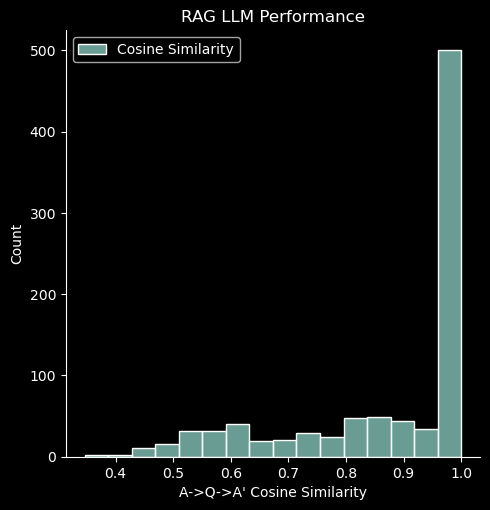

In [144]:
sns.displot(df_ground_truth['cosine_similarity'], label='Cosine Similarity')
plt.title("RAG LLM Performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()
plt.show()


## LLM-as-a-Judge

In [49]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_original}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {answer_original}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [80]:
df_judge = pd.read_csv('ground_truth_metrics_rag.csv',sep=';', encoding='utf-8')

### Testing

In [81]:
list_judge = df_judge.to_dict(orient='records')

# n_rows = limit_rows
# df_judge = df_ground_truth_gpt.sample(n=n_rows, random_state=1)
# list_judge = df_judge.to_dict(orient='records')


In [84]:
len(list_judge)

902

In [85]:
record = list_judge[0]
record

{'number': '1',
 'question': 'What is the genus of the Glimmerfox?',
 'answer': 'The genus of the Glimmerfox is Vulpilynx, a synthetic taxon designed to encompass its unique evolutionary lineage. It combines traits from foxes (Vulpes) and lynxes (Lynx), representing its hybrid characteristics.',
 'sanitized_question': 'what_is_the_genus_of_the_glimm',
 'document_id': 'doc_1_what_is_the_genus_of_the_glimm',
 'answer_original': 'The genus of the Glimmerfox is Vulpilynx, a synthetic taxon designed to encompass its unique evolutionary lineage. It combines traits from foxes (Vulpes) and lynxes (Lynx), representing its hybrid characteristics.',
 'answer_llm': 'The genus of the Glimmerfox is Vulpilynx.',
 'cosine_similarity': 0.6805863567983683,
 'vector_original': '[-0.23059779 -0.28381643  0.01923009 -0.04445119 -0.09853733  0.58299392\n  0.22555427 -0.16872858  0.0565829  -0.01073218  0.0039366  -0.05047371\n -0.29283449 -0.01519125 -0.17183313 -0.06612317 -0.07828501 -0.07258251\n -0.0401

In [86]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: The genus of the Glimmerfox is Vulpilynx, a synthetic taxon designed to encompass its unique evolutionary lineage. It combines traits from foxes (Vulpes) and lynxes (Lynx), representing its hybrid characteristics.
Generated Question: What is the genus of the Glimmerfox?
Generated Answer: The genus of the Glimmerfox is Vulpilynx.

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief e

In [87]:
result = llm(prompt, model_choice='openai/gpt-4o-mini', api_key=openai_api_key)
print(result)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly and accurately states the genus of the Glimmerfox as Vulpilynx, which is the key information presented in the original answer. Although it does not include the additional context about the synthetic taxon or its hybrid characteristics, it effectively answers the question posed."
}


In [88]:
result_dict = json.loads(result)
relevance_value = result_dict['Relevance']
relevance_value

'RELEVANT'

### Evaluation for prompt 1

In [89]:
evaluations_1 = []

for record in tqdm(list_judge):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model_choice='openai/gpt-4o-mini', api_key=openai_api_key)
    evaluations_1.append(evaluation)

  0%|          | 0/902 [00:00<?, ?it/s]

In [91]:
evaluations_1[:5]

['{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer directly responds to the question about the genus of the Glimmerfox by providing the exact information stated in the original answer. It maintains the same fact without any loss of meaning."\n}',
 '{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides the exact species designation of the Glimmerfox as stated in the original answer, making it entirely relevant and accurate to the question asked."\n}',
 '{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer accurately reflects the content of the original answer, directly addressing the significance of the species epithet \'chameleontis\' by explaining its meaning and how it relates to the Glimmerfox\'s abilities and adaptations."\n}',
 '{\n  "Relevance": "PARTLY_RELEVANT",\n  "Explanation": "The generated answer discusses the unique combination of traits of the Glimmerfox, touching on themes of color changes and behaviors, whi

In [92]:
json_evaluations_1 = []
relevance_list_1 = []
explanation_list_1 = []

for i, str_eval in enumerate(evaluations_1):
    json_eval = json.loads(str_eval)
    # json_evaluations.append(json_eval)
    relevance = json_eval['Relevance']
    explanation = json_eval['Explanation']

    relevance_list_1.append(relevance)
    explanation_list_1.append(explanation)

In [93]:
len(df_judge), len(relevance_list_1), len(explanation_list_1)

(902, 902, 902)

In [94]:
type(df_judge)

pandas.core.frame.DataFrame

In [95]:
df_judge['relevance_1'] = relevance_list_1
df_judge['explanation_1'] = explanation_list_1

In [96]:
df_judge.relevance_1.value_counts()

relevance_1
RELEVANT           591
NON_RELEVANT       163
PARTLY_RELEVANT    148
Name: count, dtype: int64

In [97]:
df_judge.to_csv('df_judge_1.csv', index=False, sep=';', encoding='utf-8')


### Evaluation for prompt 2

In [98]:
df_judge = pd.read_csv('df_judge_1.csv',sep=';', encoding='utf-8')

In [99]:
df_judge.head()

,number,question,answer,sanitized_question,document_id,answer_original,answer_llm,cosine_similarity,vector_original,vector_llm,relevance_1,explanation_1
0,1,What is the genus of the Glimmerfox?,"The genus of the Glimmerfox is Vulpilynx, a sy...",what_is_the_genus_of_the_glimm,doc_1_what_is_the_genus_of_the_glimm,"The genus of the Glimmerfox is Vulpilynx, a sy...",The genus of the Glimmerfox is Vulpilynx.,0.680586,[-0.23059779 -0.28381643 0.01923009 -0.044451...,[ 0.05953924 -0.15275596 -0.13346344 -0.042982...,RELEVANT,The generated answer directly responds to the ...
1,2,What is the species designation of the Glimmer...,The species designation of the Glimmerfox is V...,what_is_the_species_designatio,doc_2_what_is_the_species_designatio,The species designation of the Glimmerfox is V...,The species designation of the Glimmerfox is V...,0.746132,[-0.22163786 -0.1949262 0.06746699 -0.232490...,[-1.39076188e-01 -4.18491930e-01 -2.30193138e-...,RELEVANT,The generated answer provides the exact specie...
2,3,What is the significance of the Glimmerfox's s...,The species epithet 'chameleontis' denotes the...,what_is_the_significance_of_th,doc_3_what_is_the_significance_of_th,The species epithet 'chameleontis' denotes the...,The species epithet 'chameleontis' denotes the...,1.000000,[-2.20516130e-01 -1.33159757e-01 1.23536274e-...,[-2.20516130e-01 -1.33159757e-01 1.23536274e-...,RELEVANT,The generated answer accurately reflects the c...
3,4,What unique combination of traits does the Gli...,The Glimmerfox possesses a combination of mamm...,what_unique_combination_of_tra,doc_4_what_unique_combination_of_tra,The Glimmerfox possesses a combination of mamm...,The Glimmerfox possesses a unique combination ...,0.878121,[ 5.99452034e-02 -3.77629668e-01 4.25340869e-...,[-0.02196432 -0.39906842 -0.06075856 -0.059261...,PARTLY_RELEVANT,The generated answer discusses the unique comb...
4,5,How does the Glimmerfox change its fur color?,The Glimmerfox changes its fur color through a...,how_does_the_glimmerfox_change,doc_5_how_does_the_glimmerfox_change,The Glimmerfox changes its fur color through a...,The context provided does not explicitly detai...,0.675825,[ 0.13540363 -0.29357302 -0.03549277 -0.096659...,[-0.03119797 -0.43565699 0.12308128 0.056156...,NON_RELEVANT,The generated answer fails to address the ques...


In [101]:
df_judge.describe()

,cosine_similarity
count,902.000000
mean,0.877508
std,0.167155
min,0.346501
25%,0.795372
50%,0.991802
75%,1.000000
max,1.000000


In [102]:
evaluations_2 = []

for record in tqdm(list_judge):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model_choice='openai/gpt-4o-mini', api_key=openai_api_key)
    evaluations_2.append(evaluation)

  0%|          | 0/902 [00:00<?, ?it/s]

In [105]:
len(evaluations_2)

902

In [103]:
evaluations_2[:5]

['{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer directly states the genus of the Glimmerfox, which is the core information provided in the original answer. It is accurate and reflects the essential part of the original response, ensuring high relevance."\n}',
 '{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer accurately restates the species designation of the Glimmerfox as Vulpilynx chameleontis, directly addressing the question posed. It maintains the context of the original answer without introducing any irrelevant information."\n}',
 '{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer is identical to the original answer and directly addresses the significance of the species epithet \'chameleontis\' as asked in the generated question."\n}',
 '{\n  "Relevance": "PARTLY_RELEVANT",\n  "Explanation": "The generated answer touches on the unique combination of traits of the Glimmerfox but diverges by introducing new elements s

In [129]:
json_evaluations_2 = []
relevance_list_2 = []
explanation_list_2 = []

for i, str_eval in enumerate(evaluations_2):
    try:
        # Removes a trailing comma from a JSON string if it exists.
        cleaned_str = re.sub(r',\s*(\}|\])', r'\1', str_eval)

        json_eval = json.loads(cleaned_str)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON at index {i}: {str(e)}")
        print(f"String that caused the error: {str_eval}")
        break
    except Exception as e:
        print(f"Unexpected error at index {i}: {str(e)}")
        print(f"String that caused the error: {str_eval}")
        break

    # json_evaluations.append(json_eval)
    relevance = json_eval['Relevance']
    explanation = json_eval['Explanation']

    relevance_list_2.append(relevance)
    explanation_list_2.append(explanation)

In [130]:
len(df_judge), len(relevance_list_2), len(explanation_list_2)

(902, 902, 902)

In [131]:
df_judge['relevance_2'] = relevance_list_2
df_judge['explanation_2'] = explanation_list_2

In [132]:
df_judge.relevance_2.value_counts()

relevance_2
RELEVANT           587
NON_RELEVANT       160
PARTLY_RELEVANT    155
Name: count, dtype: int64

In [133]:
df_judge.to_csv('df_judge_1_2.csv', index=False, sep=';', encoding='utf-8')


In [134]:
elapsed_time = time.time() - start_time
print(f"Task completed in {elapsed_time:.2f} seconds.")

Task completed in 7388.04 seconds.


In [135]:
print(f"Task completed in {elapsed_time//60:.2f} minutes.")

Task completed in 123.00 minutes.
